# GPUs and GWs

To work on a GPU in colab, go to `Runtime`-->`Change runtime type` and switch from `None` to `GPU`. Also make sure `run_simulator` below is set to `False`.

If working with `numba.cuda` simulator, set `run_simulator` just below here to `True`. In this state, not all functionality (especially `CuPy`) will be available. 

In [ ]:
run_simulator = False

if run_simulator:
    %env NUMBA_ENABLE_CUDASIM=1
    import numpy as xp

else:
    import cupy
    import cupy as xp

from numba import cuda

import numpy
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

## Introduction

The purpose of this tutorial is to introduce members of the GW community to coding with GPUs and how to think about using Graphics Processing Units (GPU) within our field. GPUs can be much more efficient in wall time, electricity usage, and overall costs for many high-performance computing algorithms.

The tutorial begins with an introduction to coding on GPUs (specifically NVIDIA GPUs with CUDA) using Python-based GPU computing libraries `numba`([numba.pydata.org/](https://numba.pydata.org/numba-doc/dev/cuda/index.html)) and `CuPy`([cupy.dev](https://cupy.dev/)). `CuPy` is an effective drop-in for `NumPy` and partially for `SciPy`. `numba` exposes an interface that mimic's the C/C++ CUDA environment in Python making it very useful to introduce further GPU concepts for development that go beyond array manipulation possible in `CuPy`. 

In the second part of the tutorial, we will add gravitational waves and LISA to the mix. We will begin by working with Galactic binary waveforms within the setting of LISA Data Analysis. We will finish with a challenge: coding up an EMRI waveform (with a bit of initial help of course...). 

A few thoughts before you begin:
* For pretty much all of the examples below, there are multiple ways to code them up. Some ways are easier versus harder, faster versus slower. When writing GPU programs, it helps to focus on the most pressing issues firsts i.e. the bottlenecks. Sometimes leaving simpler code that does not need speeding up to the "simpler" "slower" versions will be helpful for more efficient development. Therefore, it is useful to understand the full spectrum of options. 
* Timing on the Colab GPUs will most likely be better than CPU timings, but the true timing compared to CPUs will be algorithm- and GPU-dependent. 
* When using the `%timeit` function, you may need to run twice do to funky aspects of synchronizing asynchronous CUDA kernel calls. If you really want to make sure the timing is okay, put the function call in its own cell, add `cuda.synchronize()` on the line after and `%%timeit` at the top of the cell (with 2 `%`). This will loop the entire cell rather than just the function call which means it will synchronize the function call each time. 


### Starting with a new GPU
First, we will check which GPU we have access to. When we call `nvidia-smi` from the command line, it tells us the memory capacity, power output, utilization, and CUDA version of the GPU we have access to. It will also tell you if there are any processes running on this GPU currently.

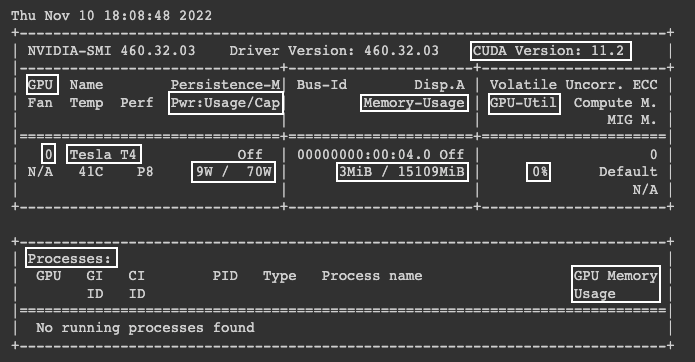

In [ ]:
!nvidia-smi

Tue Nov 15 11:25:30 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

As we start to write our codes in Python, we may have to select the right GPU. On Colab, this is not necessary because we only have access to one GPU. It will have index zero as you can see above in the output from the `nvidia-smi` command. To confirm our GPU is index zero, we can use `CuPy`:

In [ ]:
xp.cuda.runtime.getDevice()

0

If you are on a workstation or any HPC setup that gives access to multiple GPUs, you will want to specify which GPU you are using to avoid any hassles. 

In [ ]:
xp.cuda.runtime.setDevice(0)

## NumPy and CuPy

`CuPy` is an effective drop in for `NumPy` that uses GPUs for array manipulation. There are a variety of functions in CuPy that cover both `NumPy` and `SciPy` functions. You can find the CuPy documentation [here](https://docs.cupy.dev/). A very helpful page is the comparison table that tells you which functions from `NumPy`/`SciPy` are implemented so far in `CuPy`: [comparison table](https://docs.cupy.dev/en/stable/reference/comparison.html?highlight=comparison%20table). There are some small differences between `CuPy` and `NumPy` you can find [here](https://docs.cupy.dev/en/stable/user_guide/difference.html?highlight=differences%20with%20numpy). 

An important note: `CuPy` calls that involve array manipulations (not memory transfers) are called and launched asynchronously. Sometimes, you may need to synchronize the GPU to get proper timing and results (`numbda.cuda.synchronize()` or `cupy.cuda.runtime.deviceSynchronize()`). 

We will start with basic array manipulations in `NumPy`/`CuPy`. To move an array from the host to device, you can use `cupy.asarray`. To move from device to host, you have to call the `.get()` attribute: `array.get()`.

In [ ]:
# cupy basics
x = np.arange(10)
y = xp.arange(10)

print(type(x), type(y))

# move numpy to cupy and cupy to numpy
# numpy --> cupy: xp.asarray
# cupy --> numpy: array.get()
print(type(xp.asarray(x)), type(y.get()))

<class 'numpy.ndarray'> <class 'cupy.ndarray'>
<class 'cupy.ndarray'> <class 'numpy.ndarray'>


We can time a variety of these array operations that are very common in every day coding. 

In [ ]:
%timeit z = np.tile(np.arange(int(1e6)), (10, 1)) * np.random.rand(10, int(1e6))
%timeit z = xp.tile(xp.arange(int(1e6)), (10, 1)) * xp.random.rand(10, int(1e6))

228 ms ± 64.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
2.69 ms ± 2.52 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### CuPy/NumPy-agnostic functions

If you are sensing a pattern here, you can generally just switch `np` to `xp` and almost everything will work out just the same. With this in mind, we can create `NumPy`/`CuPy`-agnostic functions. This allows a user to choose what is prefered.

The way I have chosen to do this is to add the array manipulation library as keyword argument to the function call. This is one way to do it. There are others. 

Important Note: If working on a workstation with multiple GPUs accessible, you may beed to put `cupy.cuda.runtime.setDevice` commands inside these functions if `CuPy` is being used. This is especially true if these functions are declared within a file where there is no call to `cupy.cuda.runtime.setDevice` set up. If this is not done, it may run whatever computations are in the this function on the index 0 GPU. 

In [ ]:
def numpy_cupy_agnostic_function(x1, y1, x2, y2, xp_here=None):
    if xp_here is None:
        xp_here = np

    x1 = xp_here.asarray(x1)
    y1 = xp_here.asarray(y1)
    x2 = xp_here.asarray(x2)
    y2 = xp_here.asarray(y2)
    
    # index in x1 that matches x2 boundaries
    inds = xp_here.searchsorted(x1, x2[xp_here.array([0, -1])], side="right") - 1
    
    ind_start = inds[0].item()
    ind_end = inds[1].item()

    # add 1 for proper slicing of array
    ind_end += 1

    length = ind_end - ind_start

    assert length == len(y2)

    out = xp_here.sum(y1[ind_start:ind_end] * y2)

    return out  


In [ ]:
dt = 10.0
x1 = np.arange(1000) * dt
y1 = np.sin(2 * np.pi * x1)

x2 = np.arange(100, 200) * dt
y2 = np.sin(2 * np.pi * x2 / 1.001)

out_numpy_1 = numpy_cupy_agnostic_function(x1, y1, x2, y2, xp_here=None)
out_numpy_2 = numpy_cupy_agnostic_function(x1, y1, x2, y2, xp_here=np)
out_cupy = numpy_cupy_agnostic_function(x1, y1, x2, y2, xp_here=xp)

print(type(out_numpy_1), type(out_numpy_2), type(out_cupy))
print(np.all(out_numpy_1 == out_numpy_2), np.all(out_numpy_1 == out_cupy.get().item()))
print(out_numpy_1,  out_numpy_2, out_cupy.get().item())
print(np.allclose(out_cupy.get().item(), out_numpy_2))

<class 'numpy.float64'> <class 'numpy.float64'> <class 'cupy.ndarray'>
True False
-4.417361438009196e-12 -4.417361438009196e-12 -4.417361438009195e-12
True


Note that the outputs of the CPU and GPU combinations are identical down to double precision. However, after that level of precision, the values may differ due to slightly different low-level algorithms for common operations. 

#### Practice
Write a `NumPy`/`CuPy`-agnostic function that computes a matrix inversion followed by multiplication with a vector. Then, add an option as a keyword argument that choses whether you want the return array as a `NumPy` or `CuPy` array regardless of the input array hardware. 

In [ ]:
def practice_multiply_and_output(mat, vec, **kwargs):
  # replace kwargs with the specific keywork arguments needed

  # fill in code to produce output array out
  # out = 
  return out

In [ ]:
# setup and call function

n = 1000
mat = np.diag(np.random.randn(n))
vec = np.random.randn(n)

practice_multiply_and_output(mat, vec, **kwargs)

##### Solution

In [ ]:

def practice_multiply_and_output(mat, vec, xp_here=None, return_cupy=False):
    if xp_here is None:
        xp_here = np

    # copy to GPU if inputing numpy arrays
    mat = xp_here.asarray(mat)
    vec = xp_here.asarray(vec)
    
    # get the inverse
    inv = xp_here.linalg.inv(mat)

    # dot with vector (can use matmul as well)    
    out = xp_here.dot(mat, vec)

    # control output array type
    if xp_here == cupy and return_cupy is False:
        out = out.get()

    elif xp_here == numpy and return_cupy:
        out = cupy.asarray(out)

    return out  


In [ ]:
n = 1000
mat = np.diag(np.random.randn(n))
vec = np.random.randn(n)

%timeit out1 = practice_multiply_and_output(mat, vec, xp_here=np, return_cupy=False)
%timeit out2 = practice_multiply_and_output(mat, vec, xp_here=np, return_cupy=True)
%timeit out3 = practice_multiply_and_output(mat, vec, xp_here=xp, return_cupy=False)
%timeit out4 = practice_multiply_and_output(mat, vec, xp_here=xp, return_cupy=True)

out1 = practice_multiply_and_output(mat, vec, xp_here=np, return_cupy=False)
out2 = practice_multiply_and_output(mat, vec, xp_here=np, return_cupy=True)
out3 = practice_multiply_and_output(mat, vec, xp_here=xp, return_cupy=False)
out4 = practice_multiply_and_output(mat, vec, xp_here=xp, return_cupy=True)

print(type(out1), type(out2), type(out3), type(out4))

106 ms ± 15.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
94 ms ± 1.45 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
32 ms ± 44.5 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
31.1 ms ± 6.34 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
<class 'numpy.ndarray'> <class 'cupy.ndarray'> <class 'numpy.ndarray'> <class 'cupy.ndarray'>


## numba

`numbda` has a small variety of capabilities when it comes to programming in CUDA. Documentation for `numba.cuda` can be found [here](https://numba.pydata.org/numba-doc/dev/cuda/index.html). In this tutorial, we will focus on one of these capabilities: its C/C++-like interface that works directly from Python and Python syntax. 

Before anyone gets scarred away by the mention of C/C++, do not worry. It is all Python. This interface is useful because it really allows us to dig into how GPUs work and how to think about programming on GPUs either in Python with `numba.cuda` or in eventually in C/C++ CUDA if that is where life takes you...

Another useful part of `numba` is that it directly interacts with `CuPy` arrays without any type of conversion, i.e. you can just put in `CuPy` arrays directly to `numba.cuda`-based functions. 

`numba.cuda` also has a "CUDA simulator." This allows the user to develop `numba.cuda` code on a CPU (or personal laptop) and actually run your program. It will not parallelize the code, but it will perform operations as if it was running on a GPU. The user can also debug in the mode which can be quite useful to preserve GPU runtime to more complete implementations of a code. More information on this topic can be found [here](https://numba.pydata.org/numba-doc/dev/cuda/simulator.html).

The key concepts we will cover in this section are how to use
* threads and blocks to properly parallelize different types of codes,
* shared memory,
* and atomic operations. 




Before we get to the code, let's review the main components of GPU parallelization and memory storage. The diagram below is useful to understand the GPU programming model at a high level. 

To start, a process running on a CPU (the host) reaches a GPU kernel call. This launches a GPU kernel as a "Grid" of "Blocks." On each block is a set of "Threads" (really it is also a grid, but to avoid confusion with Grids, I am using "set"). Threads are the smallest programatic unit on a GPU. Threads are where the code is actually executed, i.e. the actual code used is written as instructions for Threads. A Block is a group of Threads that can interact with one another (more easily than Threads on different Blocks). One form of this interaction is they can share memory through the use of "Shared Memory," which we will discuss shortly. Blocks must have a multiple of 32 as the number of Threads. Both of these units of parallelization, the Block and the Thread, are essential core concepts for programming on GPUs. Both Blocks and Threads can be indexed in three dimensions (x,y,z). When coding, you can access information of the current Thread and Block using the some commands listed below. These commands appear as `numba.cuda.{command}` in `numba` and just `{command}` in C/C++. For example, `threadIdx.x` in C/C++ would be `numba.cuda.threadIdx.x`.

* threadIdx.x (.y, .z): Index of the Thread on its Block in up to 3D.
* blockIdx.x (.y, .z): Index of the Block in the larger grid (within one kernel). 
* blockDim.x (.y, .z): Dimensions of a singular Block. This value is constant for each individual kernel call. 
* gridDim.x (.y, .z): Dimension of the Grid for a given kernel call. This is the number of Blocks along each dimension. 

### Designing your Grid

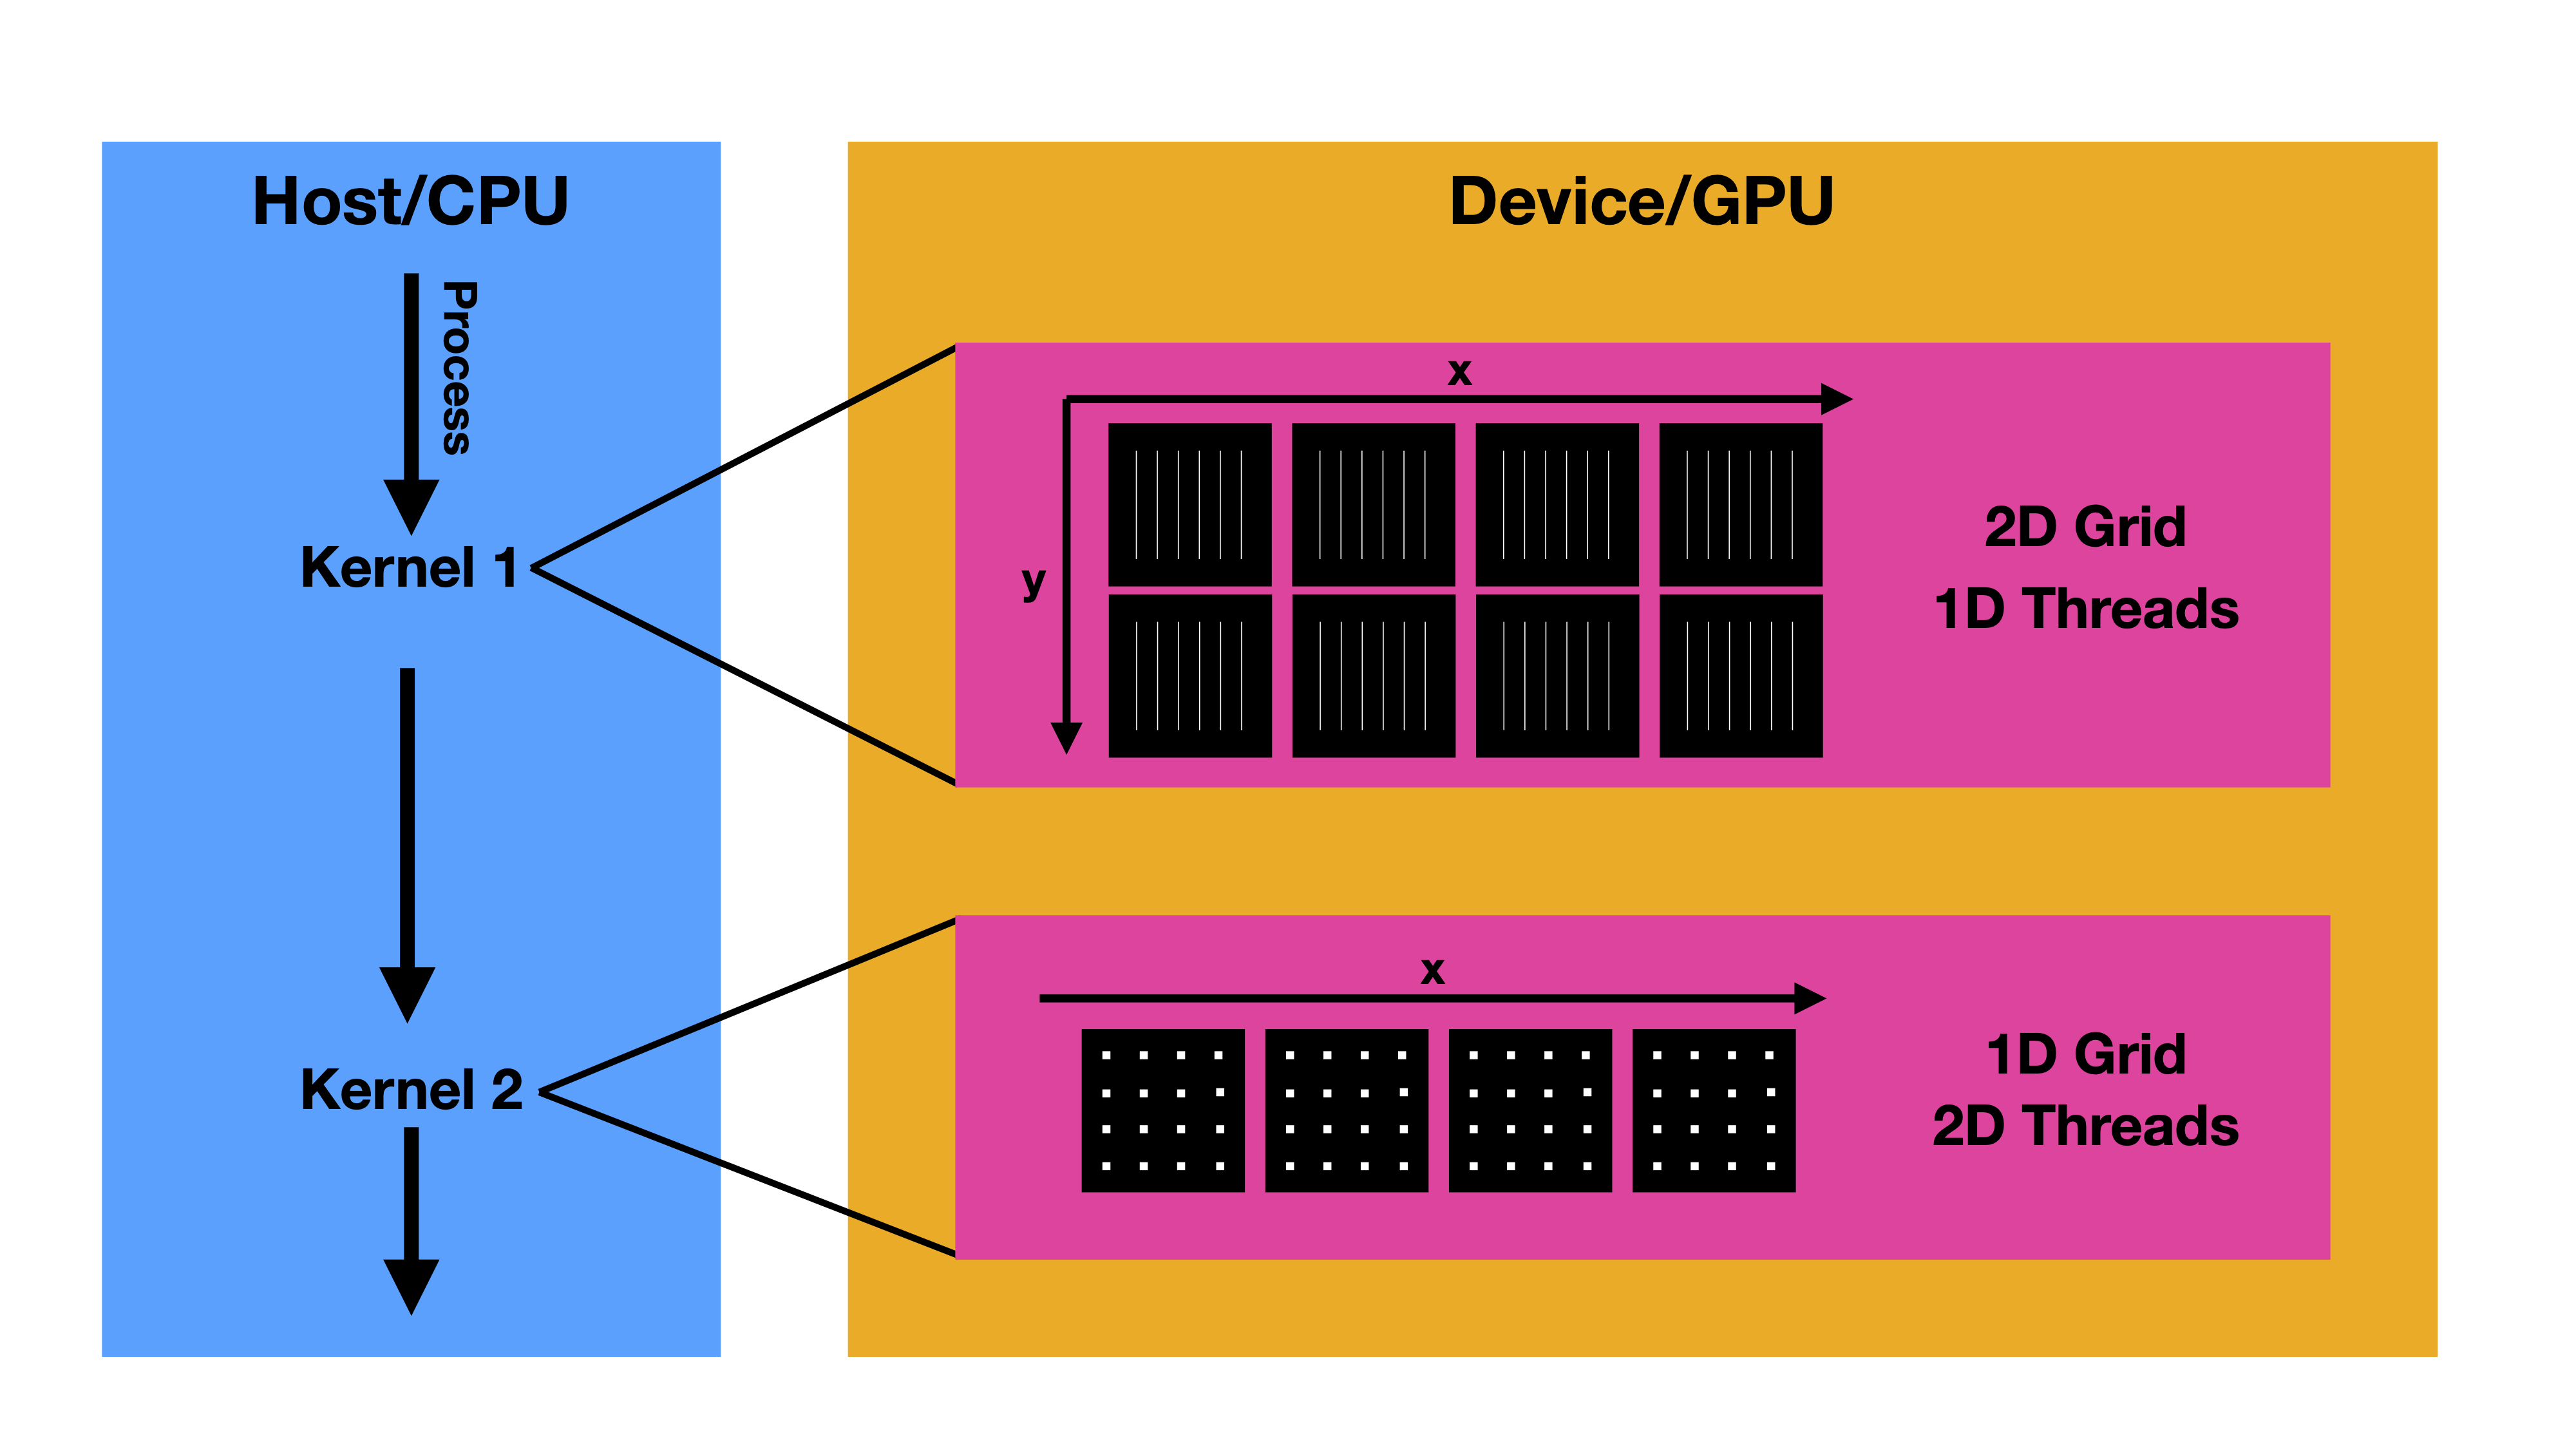

In order to leverage the full parallelization capabilities of the GPU, we combine these specialized indexing calls to efficiently access memory and perform computations. If we are performing vector-vector multiplication as an example, we want to parallelize so that the $i$th Thread performs reading in of $i$th data point from the input vectors, multiplies them together, and then outputs them to the $i$th index position of the output array. We will generalize this computation to large arrays by using a 1D Grid of M Blocks with 1D set of K Threads on each Block (multiple of 32). In Python syntax, you can determine the number of Blocks you need for an array of length N with the following equation:
```
threadsperblock = 256
blockspergrid = (len(array) + (threadsperblock - 1)) // threadsperblock
```
This will determine the number of Blocks you need to run every element of the array. Since Blocks are of fixed length (and multiples of 32), your final Block in your 1D Grid may use less than the full number of Threads. When this occurs, you must be careful and protect against accessing memory beyond the available storage of the input/output arrays. See the below for an example of this. When inside the GPU kernel, we can think of each Thread acting independently, asychronously, and simultaneously. A large number of Blocks also run simultaneously. This is not generally true though for larger Grids. Therefore, we can code the array multiplication like this (I start to use `cuda` here in place of `numba.cuda` when writing code):
```
# which block you are on * the dimensions of each block + which thread you are on
i = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x

# protect against memory errors
if i < N:
    ouput_array[i] = input_array_1[i] * input_array_2[i]
```
Compare this to the code for a loop over this computation:
```
for i in range(n):
    ouput_array[i] = input_array_1[i] * input_array_2[i]
```
This illustrates a great way to think about the usage of GPUs: simultaneously running multiple parts of a non-serialized loop computation. 

In general, it is recommended to avoid multidimensional arrays in CUDA unless absolutely necessary. When using 2D+ dimensional arrays in Python (which are really stored linearly in memory), you want to flatten these arrays and then use special 1D indexing into your 2D array. In the following code block example, we show this special 1D indexing for 2D array multiplication. We also show how to build the Grid for a 2D multiplication. This is for the sake of the tutorial. The easiest and most efficient way to do 2D array multiplication is to flatten the two arrays and multiply along the full flattened array as a 1D multiplication problem.

Here, we build a 2D grid. The x dimension represents the 1st dimension of the array. The y axis of the Grid is the second dimension of the array. 
```
dim2, dim1 = array.shape
threadsperblock = 256
blockspergrid = (dim1 + (threadsperblock - 1)) // threadsperblock

grid = (blockspergrid, dim2, 1)
```
Inside the kernel, the function looks like this:
```
# which block you are on * the dimensions of each block + which thread you are on
# this gives the value along the first dimension
i = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x

# which block in the y direction giving the second dimension. 
j = blockIdx.y

# protect against memory errors
if i < N and j < dim2:
    # here is the special indexing
    special_index = j * dim1 + i
    ouput_array[special_index] = input_array_1[special_index] * input_array_2[special_index]
```

First, we declare our CUDA kernel by adding a Python decorator to our function: `cuda.jit`. In C/C++, this becomes `__global__`. 

In [ ]:
@cuda.jit
def multiply(z, x, y, n):
    """
    Multiply two numbers (x,y) and output to new array (z).

    """
    # get index into the arrays
    i = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x

    # block memory overrun
    if i < n:
      z[i] = x[i] * y[i]

We then declare our arrays and fill them and set up the Grid information. We invoke the kernel call with the following syntax:
```
kernel_function[Grid dimensions, Block dimensions](*args)
```
Here `Grid dimensions` and `Block dimensions` can either be an integer representing a 1D grid along x or a tuple of length 3 for the dimension along (x,y,z). It is not common (at least in the author's experience in gravitational waves) that more than 1 dimension is needed for Threads, i.e. `Block dimensions`. It is common to use more than dimension for `Grid dimensions` as we will see. The main reason for this difference is the concept of memory coalescence. We will discuss this below in the next section.  

In [ ]:
threadsperblock = 32  # multiple of 32

# prepare cupy arrays
n = int(5e7)
x = xp.random.rand(n)
y = xp.random.rand(n)
z = xp.zeros_like(x)
blockspergrid = (n + (threadsperblock - 1)) // threadsperblock

# run kernel
multiply[blockspergrid, threadsperblock](z, x, y, n)
cuda.synchronize()

In [ ]:
# time the differences
%timeit multiply[blockspergrid, threadsperblock](z, x, y, n)
cuda.synchronize()
%timeit z = x * y
cuda.synchronize()
x1 = x.get()
y1 = y.get()
%timeit z1 = x1 * y1

4.95 ms ± 22 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
4.67 ms ± 7.09 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
105 ms ± 6.33 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Now we will look at 2D array multiplication. Here we will multiply a 2D matrix with dimensions (m, n) and a vector of length n along each row. This will be stored in an output matrix with shape (m, n). And just as an added bonus, here we will show the basic way to create "device functions" in `numba.cuda`. Device functions are functions that can return a value and be called from a CUDA kernel. The way you declare a device function in `numba.cuda` is by adding the `device=True` keyword argument to the `@cuda.jit` call. 

In [ ]:
@cuda.jit(device=True)
def multiply_operation(val1, val2):
    return val1 * val2

@cuda.jit
def multiply_mat_vec(z, x, y, n, m):
    """
    Multiply a matrix (x) with a vector (y) along the rows of the matrix and output to another matrix (z).
    """
    # code elided here; read further for different implementations
    i = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    j = cuda.blockIdx.y
    # could also be 
    # for j in range(m):
    #   for i in range(n):
    if i < n and j < m:
        special_index = j * n + i
        # notice the matrices are indexed with the special index
        # the vector is indexed with i
        # we are also calling the device function here
        z[special_index] = multiply_operation(x[special_index], y[i])

In [ ]:
threadsperblock = 32

n = int(1e6)
m = 50
x = xp.random.rand(m, n).flatten()
y = xp.random.rand(n)
z = xp.zeros_like(x)


blockspergrid = (n + (threadsperblock - 1)) // threadsperblock
num_sets = m
grid = (blockspergrid, num_sets, 1)
multiply_mat_vec[grid, threadsperblock](z, x, y, n, m)
cuda.synchronize()

In [ ]:
%timeit multiply_mat_vec[grid, threadsperblock](z, x, y, n, m)
cuda.synchronize()
x = x.reshape(m, n)
%timeit z2 = x * y[None, :]
z2 = x * y[None, :]
cuda.synchronize()
x1 = x.get()
y1 = y.get()
%timeit z1 = x1 * y1[None, :]
z1 = x1 * y1[None, :]

assert xp.allclose(z.reshape(m, n), z2)

5.51 ms ± 1.18 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
4.66 ms ± 1.38 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
96.4 ms ± 10.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


### GPU Memory Structure

GPUs have a few different types of memory structures that, when leveraged properly, can ensure maximal efficiency of your algorithm. 

The first type of memory is "Global" memory. Global memory is the "device RAM" or DRAM. The amount of DRAM (~GBs) can be found using the `nvidia-smi` command shown above. Global memory is accessible to all Blocks/Threads within all kernel calls and stores all the data stored on the GPU. This memory is technically not stored on the GPU chip. Therefore, it is "off chip" memory which means it is relatively slow to access. 

The second most commonly used type of array storage memory on the GPU is "Shared" memory. Shared memory is "on chip" making it fast to access. The downside is that the storage is very small and it is declared for each kernel call meaning you cannot store arrays in Shared memory prior to a kernel call. You must add values to Shared memory (maybe transfered from Global memory) inside of the kernel. Leveraging Shared memory properly can be key to accelerating certain algorithms. 

The final type of memory is Local memory, which has roughly 512 kB available (GPU dependent). Local memory is a part of DRAM, so it is slow to access. It is used when declaring arrays per Thread, i.e. only a single Thread has access to that array and each Thread has its own version of that array. 

**Please note**: when declaring variables within the CUDA kernel, you are technically using what is called "Registers" to store the memory. These are the fastest accessible on-chip memory, but there are only ~250 Registers per Thread. For most codes, this can be sufficient. If you declare a small array, e.g. `array[3]`, if there are remaining registers available, it will store this information in the registers. If all registers are used, the compiler will use Local (slow off-chip) memory. 

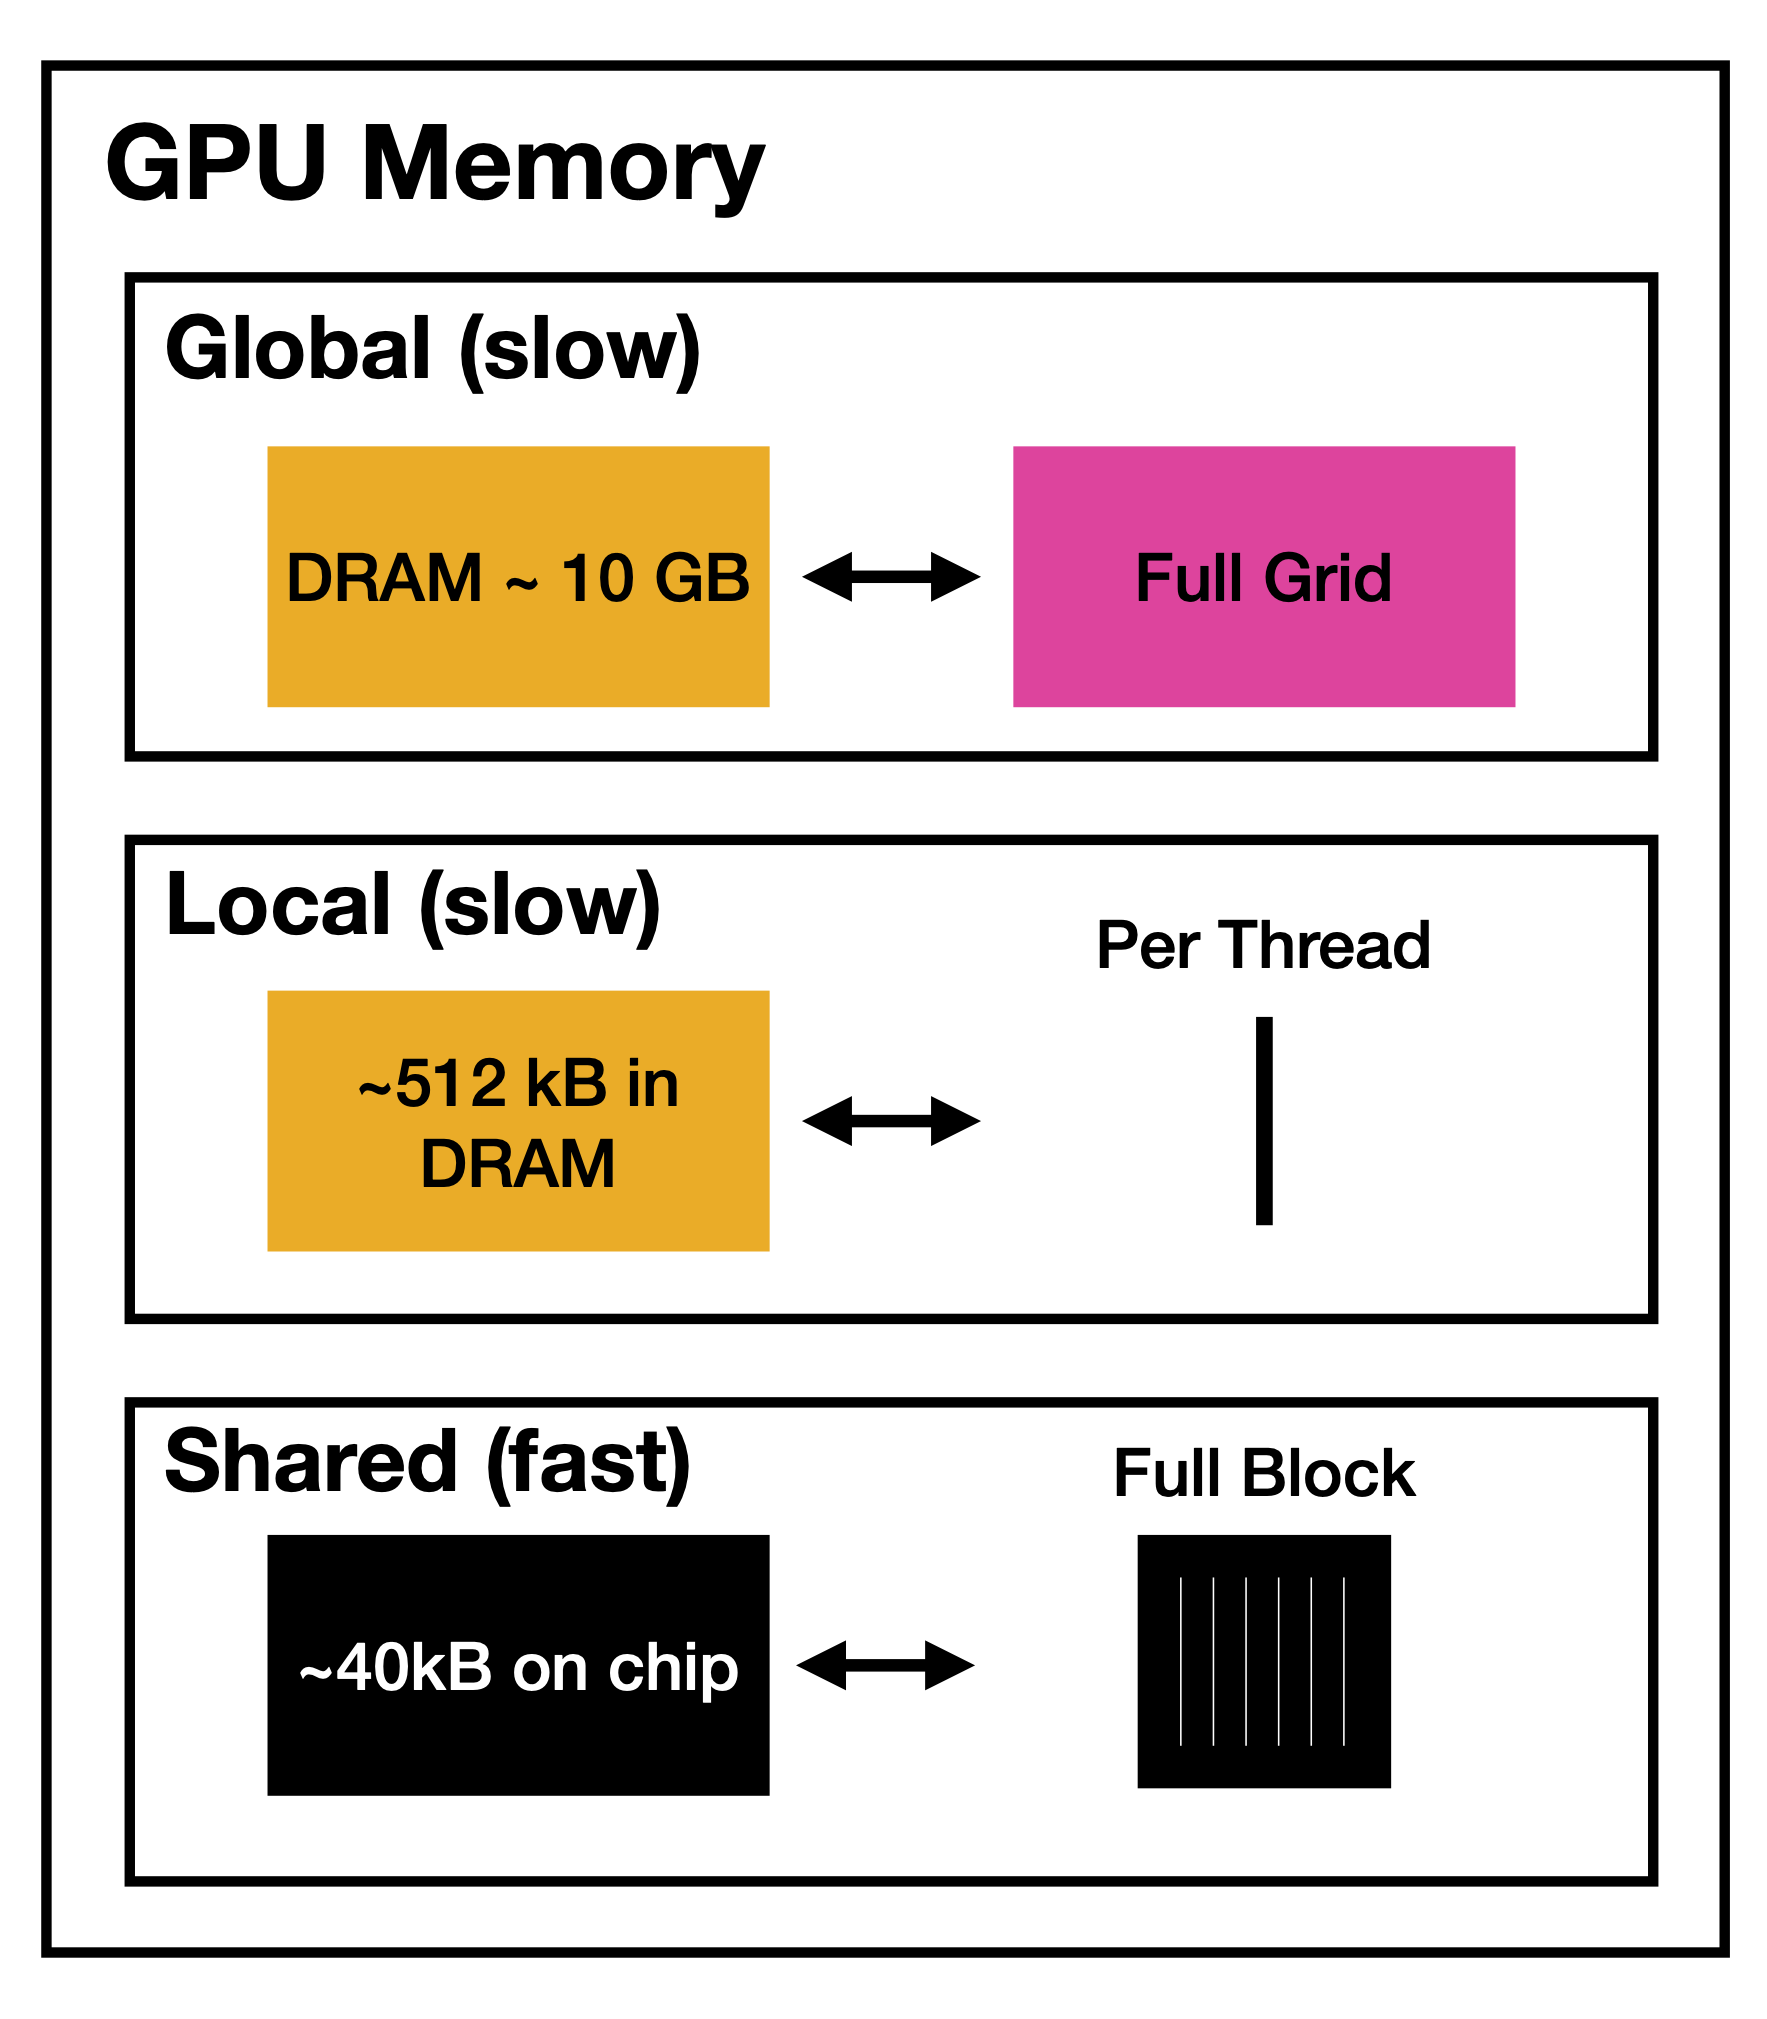

#### Memory Coalescence

"Memory Coalescence" is absolutely crucial for GPU algorithm performance. It is a term used to mean "batched consecutive memory retrieval." Let's break that down:
* Consecutive: consecutive linear addresses in memory (index 0, 1, 2, 3, 4..)
* Batch: the GPU makes a call to memory in what is called a "warp" of up to 32 threads at a time. If the memory addresses of the warp are consecutive, it can make one read for all 32 elements, rather than 32 separate reads for each element. 

In coding terms, this means that **neighboring threads access neighboring locations in memory**. This is why I generally do not use more than 1 dimensional Blocks (i.e. just x direction in Threads). The. memory coalescence in more than 1D can be difficult. Over Grid dimensions of the Blocks, this is not a concern because is the Thread unit we are concerned with in terms of Memory Coalescence. 

In our first example above with 1D multiplication,
```
ouput_array[i] = input_array_1[i] * input_array_2[i]
```
we were already using memory coalescence. 

In the second example with 2D array manipulation, we were also using memory coalescence. However, this time it was a bit more complicated. With 1D arrays, memory coalescence is more natural. With 2D, you need to ensure the memory coalescence along the Thread dimension x matches your inner most dimension, the $n$ dimesion of the array we used above. 
```
# memory coalescence along x
# we need this to be the innermost dimension of the matrix so that its memory address are neighboring each other. 
i = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x

j = cuda.blockIdx.y

# this ensures we are memory coalescing by making the i index be along neighboring threads
special_index = j * n + i

# we also ensure memory coalescence with the y array 
z[special_index] = x[special_index] * y[i]
```

Below, we will compare the same function as above, but this time we transpose the input matrix and keep the parallelization Grid in the same form just to highlight the difference when memory is not coalescing. In this example, we will make the parallelization in Threads along the `i` index, but now this index is directing the 2nd dimension of the matrix rather than the 1st as in the Memory Coalescence example above. 

In [ ]:
@cuda.jit
def multiply_mat_vec_no_memory_coalescence(z, x, y, n, m):
    """
    Multiply a matrix (x) with a vector (y) along the rows of the matrix and output to another matrix (z).
    Purposefully destroy Memory Coalescence by indexing the Thread parallelization in 
    the second dimension of the matrix rather than the 1st. 
    """
    # code elided here; read further for different implementations
    i = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    j = cuda.blockIdx.y
    if i < n and j < m:
      special_index_bad = i * m + j 

      # we are technically still memory coalescing our reads to the y array
      z[special_index_bad] = x[special_index_bad] * y[i]

In [ ]:
threadsperblock = 32

n = int(1e6)
m = 50
x = xp.random.rand(m, n).flatten()
y = xp.random.rand(n)
z = xp.zeros_like(x)


blockspergrid = (n + (threadsperblock - 1)) // threadsperblock
num_sets = m
grid = (blockspergrid, num_sets, 1)



In [ ]:
%timeit multiply_mat_vec[grid, threadsperblock](z, x, y, n, m)
cuda.synchronize()
# transpose x so that the parallelization is the outer dimension, not the inner dimension
x_bad = x.reshape(m, n).T.flatten().copy()
z_bad = xp.zeros_like(x_bad)
%timeit multiply_mat_vec_no_memory_coalescence[grid, threadsperblock](z_bad, x_bad, y, n, m)
np.allclose(z.reshape(m, n), z_bad.reshape(n, m).T)

5.35 ms ± 461 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
70.9 ms ± 217 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


array(True)

#### Shared Memory

Shared Memory is extremely lightweight on-chip memory. It is a small memory pool, but useful.

When declaring shared arrays within your kernel, the memory must be known at compile time meaning the length and data type of the array must be known. This is not necessarily true in C/C++, but that is more complicated.

Shared memory arrays are decleared with this syntax:
```
numba.cuda.shared.array(shape, type)
```
`type`: a `numba` type from this [list](https://numba.pydata.org/numba-doc/latest/reference/types.html#numba-types). The ones we commonly need are "i8" for 64-bit integer, "i4" for 32-bit integer, "c16" for double precision complex, and "f8" for double precision real values. Shape can be 2D because shared arrays are on chip. They do not have to be efficiently accessed from off-chip practically requiring the base 1D structure.

One useful command when using Shared memory (and in other applications) is the command to synchronize the Threads on a Block: `cuda.synchthreads()` in Python or just `syncthreads();` in C/C++. This command halts execution on the asynchronously running threads until they all reach that point. 

We will now do an example where we want to fill a 2D histogram based on input vectors x and y. We want to store this histogram in shared memory so that we can operate with it later on. We will add one complication: there will be multiple equally sized groups of and x and y that need to be fit into intra-group 2D histograms. We will set the number of x and y bins up front. We are going to parallelize this problem so that each individual block will handle 1 whole group, therefore filling 1 2D histogram in shared memory. 

In [ ]:
# needs to be known at compile, i.e. it cannot be dynamically determined
# there is a limit to shared memory, and this effects allocation of resources,
# so we should be careful and set a reasonable number. 
XBINS = 10
YBINS = 12

TOTAL_BINS = XBINS * YBINS

@cuda.jit
def shared_memory_example(output_2d_hist, x, y, n, groups, dbinx, dbiny):
    """
    Fill 2D histogram for each group on a given block
    """

     

    # declared our shared array in 
    hist_2d_shared = cuda.shared.array((XBINS, YBINS), "i8")

    # set to zeros
    for bin_i in range(cuda.threadIdx.x, TOTAL_BINS, cuda.blockDim.x):
        bin_x = int(bin_i // YBINS)
        bin_y = int(bin_i % YBINS)

        if bin_i > TOTAL_BINS:
            continue

        # memory is coalesced based on index bin_i -> thread indicator
        hist_2d_shared[bin_x, bin_y] = 0

    # sync threads after zeroing
    cuda.syncthreads()  

    # "loop" over groups
    for group in range(cuda.blockIdx.x, groups, cuda.gridDim.x):
        # "loop" over points in each group
        for i in range(cuda.threadIdx.x, n, cuda.blockDim.x):
            # group * number of points per group + point within group
            index = group * n + i

            # bin_x and bin_y and the bin indices
            bin_x = int(x[index] // dbinx)
            bin_y = int(y[index] // dbiny)

            # just for memory protection
            if bin_x < 0:
                bin_x = 0
            elif bin_x >= XBINS:
                bin_x = XBINS

            if bin_y < 0:
                bin_y = 0
            elif bin_y >= YBINS:
                bin_y = YBINS

            # choose atomic or not

            # increase the counter in this bin
            hist_2d_shared[bin_x, bin_y] += 1

            # toggle this for atomic operations
            # cuda.atomic.add(hist_2d_shared, (bin_x, bin_y), 1)

        # synchronize the threads before we read out the information
        cuda.syncthreads()

        # need to do memory coalescence for output
        # need to careful with 2D bin array
        for bin_i in range(cuda.threadIdx.x, TOTAL_BINS, cuda.blockDim.x):
            bin_x = int(bin_i // YBINS)
            bin_y = int(bin_i % YBINS)

            if bin_i > TOTAL_BINS:
                continue

            # memory is coalesced based on index bin_i -> thread indicator
            output_2d_hist[group * TOTAL_BINS + bin_i] = int(hist_2d_shared[bin_x, bin_y])       
    

In [ ]:

# set limits
xmin, xmax = 0.0, 1.0
ymin, ymax = 0.0, 2.0

dbinx = (xmax - xmin) / XBINS
dbiny = (ymax - ymin) / YBINS

# values per group 
n = 1000
groups = 10

x_vals = xp.random.uniform(xmin, xmax, size=(groups, n)).flatten()
y_vals = xp.random.uniform(ymin, ymax, size=(groups, n)).flatten()


In [ ]:

# must match shared array data type
output_2d_hist = xp.zeros((groups, TOTAL_BINS)).flatten().astype(xp.int64)

grid = (groups, 1, 1)
NUM_THREADS = 32
shared_memory_example[grid, NUM_THREADS](output_2d_hist, x_vals, y_vals, n, groups, dbinx, dbiny)
cuda.synchronize()
output_2d_hist.reshape(groups, XBINS, YBINS)[0]

/usr/local/lib/python3.7/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 10 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


array([[ 9,  7,  8, 11,  9,  4,  8,  7,  6,  5,  6,  5],
       [ 6, 10,  6,  8,  9,  6,  6,  8, 10,  8,  5,  6],
       [ 6,  8,  6, 10,  5,  6,  7,  6,  6,  6,  9,  5],
       [13,  9,  8,  8,  5, 12,  4,  7,  8, 10,  8, 11],
       [ 7,  8, 11, 11,  6,  7,  3,  8,  8,  9,  9, 12],
       [ 8, 10,  8,  5,  8,  8,  9, 11,  5,  6,  6,  7],
       [ 6,  9,  7,  7,  8,  6,  8,  5,  8,  8,  6, 10],
       [ 9,  6,  9,  5,  7,  4,  5,  6,  5, 10,  3,  6],
       [11,  6, 14, 10,  8,  8,  7, 10,  9,  2,  3,  6],
       [ 9,  5,  7,  4,  3,  8,  7,  4,  6,  9,  4,  5]])

#### Atomic Operations

"Race Conditions" occur when multiple threads asynchronously attempt to update a single value in memory. To prevent Race Conditions we use "Atomic Operations." Atomic Operations will sequentially operate on an array based on the order of operations that come in from the asynchronous threads. 

In C/C++, the line `hist_2d_shared[bin_x, bin_y] += 1` would generate a race condition. There would be an add to a memory location coming from more than one Thread. In `numba.cuda`, it seems to have managed this specific example. However, other race conditions are possible in `numba.cuda`. But, for the sake of explanation, if you comment out that `+=` line and uncomment the `cuda.atomic.add` below, that is how you substitute in the atomic operation. The call to this atomic operation is:
```
add(ary, idx, val)
```
* `ary`: array to add the value to.
* `idx`: index into `ary`.
* `val`: value to add to `ary[idx]`. 

More informaation on available atomic operations within `numba.cuda` can be found [here](https://numba.pydata.org/numba-doc/latest/cuda/intrinsics.html). 


#### Reductions

There is also a specialized parallel summation method on GPUs called a Reduction. Reduction algorithms can be written into kernels or you can use a predefined reduction method from `CuPy` ([here](https://docs.cupy.dev/en/stable/user_guide/kernel.html)) or `numba` ([here](https://numba.pydata.org/numba-doc/dev/cuda/reduction.html)). These are just beyond the scope of this tutorial, but they can be very useful in accelerating certain algorithms. 

#### Practice

We will now practice the skills we have learned in `numba.cuda`. Here is the task:

* We have `num_vecs` number of length 3 vectors. We have `num_rots` number of rotation matrices we want to apply to each of these vectors. We will assume `num_vecs` >> `num_rots`. Write a CUDA kernel that will rotate each vector by *each* rotation matrix and output to an array that has final shape (num_vecs, num_rots, 3).
* Design a Grid for this problem. Keep in mind that `num_vecs` >> `num_rots`. Hint: you want to use the smaller parallelization unit on the larger dimension.
* Use shared memory to store the input vector to be rotated, the output vector after rotation, and the rotation matrix.
* Use at least one device function if you can. 
* Hint: Be careful with memory coalescence, especially on the output array of vectors.

I will get you started by declaring the number of threads up front for any use in shared memory calls and by offering a start with the shared memory arrays that makes this problem a bit easier to deal with. I have also added the generation of the input arrays. Good luck!

In [ ]:
NUM_THREADS = 256


@cuda.jit
def large_rotation(out_rot_vecs, rot_mats, vecs, num_rots, num_vecs):

    # thread index that we are on
    tid = cuda.threadIdx.x

    # shared arrays for vectors
    # I will do this part because it really helps for indexing

    # need to declare shared memory at the block level. 
    # we need NUM_THREADS vectors, so we need NUM_THREADS * 3 values in memory. 
    shared_vec_in_all = cuda.shared.array(NUM_THREADS * 3, "f8")
    shared_vec_out_all = cuda.shared.array(NUM_THREADS * 3, "f8")

    # in order to index so that only the vector for this thread is in the shared array
    # we can slice the full block array for each thread
    # THESE ARE THE ARRAYS YOU SHOULD USE AS THEY ARE PARTICULAR TO EACH THREAD
    # they have length 3 for x,y,z for 1 input/output vector
    shared_vec_in = shared_vec_in_all[tid * 3:(tid + 1) * 3]
    shared_vec_out = shared_vec_out_all[tid * 3:(tid + 1) * 3]

    # declare the shared array for the rotation matrix here
    # I recommend reading in in 1 dimension to practice indexing in one dimension
    # and how to properly use memory coalescence 

    
    ### Your Turn!!  ### 



In [ ]:
num_vecs = 100
num_rot_mats = 20

# get rotation angles
angle = xp.random.rand(num_rot_mats)

# get rotation matrices
rot_mats = xp.asarray([
  [xp.cos(angle), -xp.sin(angle), xp.zeros_like(angle)],
  [xp.sin(angle), xp.cos(angle), xp.zeros_like(angle)],
  [xp.zeros_like(angle), xp.zeros_like(angle), xp.ones_like(angle)]
]).transpose(2, 1, 0)

# get input vectors
vecs = xp.random.randn(3, num_vecs).flatten()


#### Solution

In [ ]:
NUM_THREADS = int(256)

# device function
@cuda.jit(device=True)
def rotate(out_vec, rot_mat, vec):

    # multiply rotation matrix by vector
    for i in range(3):
        temp_sum = 0.0
        for j in range(3):
            temp_sum += rot_mat[i * 3 + j] * vec[j]

        # output to output vector
        out_vec[i] = temp_sum

    return

@cuda.jit
def large_rotation(out_rot_vecs, rot_mats, vecs, num_rots, num_vecs):

    # thread index that we are on
    tid = cuda.threadIdx.x

    # shared arrays for vectors
    # I will do this part because it really helps for indexing

    # need to declare shared memory at the block level. 
    # we need NUM_THREADS vectors, so we need NUM_THREADS * 3 values in memory. 
    shared_vec_in_all = cuda.shared.array((NUM_THREADS,), "f8")
    shared_vec_out_all = cuda.shared.array((NUM_THREADS,), "f8")

    # in order to index so that only the vector for this thread is in the shared array
    # we can slice the full block array for each thread
    # THESE ARE THE ARRAYS YOU SHOULD USE AS THEY ARE PARTICULAR TO EACH THREAD
    # they have length 3 for x,y,z for 1 input/output vector
    shared_vec_in = shared_vec_in_all[tid * 3:(tid + 1) * 3]
    shared_vec_out = shared_vec_out_all[tid * 3:(tid + 1) * 3]

    shared_rot_mat = cuda.shared.array(9, "f8")
    
    # get indexing information for GPU to put in for loop
    start = cuda.threadIdx.x + cuda.blockDim.x * cuda.blockIdx.x
    increment = cuda.blockDim.x * cuda.gridDim.x

    # "loop" over blocks in the y dimension representing which rotation 
    # is being performed on this entire block
    for rot_j in range(cuda.blockIdx.y, num_rots, cuda.gridDim.y):

        # read in the rotation matrix to shared memory
        for i in range(cuda.threadIdx.x, 9, cuda.blockDim.x):
            shared_rot_mat[i] = rot_mats[rot_j * 9 + i];

        cuda.syncthreads()

        # "loop" over the vectors assigning one to each thread
        for vec_i in range(start, num_vecs, increment):
            # loop over index into the length 3 vector (x,y,z)
            for k in range(3):
                # read in the vector from global memory to shared
                # need to make sure the index of the vector is the innermost dimension
                # the vector has shape (3, num_vecs) for memory coalescence
                shared_vec_in[k] = vecs[k * num_vecs + vec_i]

            # rotate
            rotate(shared_vec_out, shared_rot_mat, shared_vec_in)

            # read out, be careful about memory coalescence
            # vec_i needs to be innermost dimension
            # shape of output array needs to be (3, num_rots, num_vecs)
            for k in range(3):
                out_rot_vecs[(k * num_rots + rot_j) * num_vecs + vec_i] = shared_vec_out[k]



In [ ]:
num_vecs = 1000
num_rot_mats = 20

# get rotation angles
angle = xp.random.rand(num_rot_mats)

# get rotation matrices
rot_mats = xp.asarray([
  [xp.cos(angle), -xp.sin(angle), xp.zeros_like(angle)],
  [xp.sin(angle), xp.cos(angle), xp.zeros_like(angle)],
  [xp.zeros_like(angle), xp.zeros_like(angle), xp.ones_like(angle)]
]).transpose(2, 1, 0)

# store shape for after comparison
rot_mats_shape = rot_mats.shape

# flatten arrays
rot_mats = rot_mats.flatten()

# input vectors
vecs = xp.random.randn(3, num_vecs).flatten()

# output vectors
out_rot_vecs = xp.zeros((3, num_rot_mats, num_vecs)).flatten()

# number of blocks needed along x direction
blockspergrid = (num_vecs + (NUM_THREADS - 1)) // NUM_THREADS

# initialize the grid
grid = (blockspergrid, num_rot_mats, 1)

# rotate everything!
large_rotation[grid, NUM_THREADS](out_rot_vecs, rot_mats, vecs, num_rot_mats, num_vecs)
cuda.synchronize()

out_rot_vecs_shaped = out_rot_vecs.reshape((3, num_rot_mats, num_vecs)).transpose(2, 1, 0)

assert xp.allclose(xp.dot(rot_mats.reshape(rot_mats_shape)[17], vecs.reshape(3, num_vecs).T[83]), out_rot_vecs_shaped[83, 17])

/usr/local/lib/python3.7/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 80 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


## Adding Gravitational Waves

Now we will apply what we have learned about CUDA to gravitational wave computations. Specifically, we are going to use GPUs to build a Galactic binary waveform and compute an inner product. We will then vectorize this process over multiple Galactic Binaries.

We will end with a challenge problem: build and EMRI waveform and calculate the Likelihood against data. 

### Galactic Binary Waveforms

We will start by building Galactic binary waveforms (without LISA response) because they are the simplest waveforms we deal with. We wil assume the following model for the source-frame Galactic binary waveforms:

$$h_+^\text{S}\approx A \cos(2 \pi (f_0t + \frac{1}{2}\dot{f}_0t^2 + \phi_0)$$

$$h_\times^\text{S}\approx A \sin(2 \pi (f_0t + \frac{1}{2}\dot{f}_0t^2 + \phi_0)$$

* $f_0$: Initial frequency in Hz.
* $\dot{f}_0$: Initial frequency derivative.
* $A$: Amplitude.
* $\phi_0$: Initial gravitational wave phase.

We then rotate these components based on the viewing angles to the source: 

$$\begin{bmatrix} h_+^\text{SSB} \\ h_\times^\text{SSB} \end{bmatrix} = \begin{bmatrix}\cos{2\psi} & -\sin{2\psi} \\ \sin{2\psi} & \cos{2\psi}\end{bmatrix}\begin{bmatrix}-(1 + \cos^2{\iota}) h_+^\text{S} \\ -(2 \cos{\iota}) h_\times^\text{S} \end{bmatrix}$$

* $\iota$: Inclination angle.
* $\psi$: Polarization angle.

This gives us the waveform polarizations at the Solar System Baricenter (SSB). In true LISA analysis, we would now apply the Response Function to get the TDI channels.


We will do this with both `numba.cuda` and `CuPy` for practice and comparison. To start, we build a kernel function in `numba.cuda`. This function takes a time vector t, scalar Galactic Binary parameter values `(A, f, fdot, phi0, inc, psi)`, and the number of time points $n$ as inputs. It also takes the allocated output arrays for $h_+$ (`hp`) and $h_\times$ (`hc`). 

There are some math functions available in `numba.cuda` through the `math` library. 

In [ ]:
import math

@cuda.jit
def gb_wave_kernel(hp, hc, t, A, f, fdot, phi0, inc, psi, n):
    """
    Build a single Galactic Binary waveform.
    """

    # get incrementing information along x axis of our Grid
    start = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    increment = cuda.blockDim.x * cuda.gridDim.x

    # "loop" over all points in the waveform
    for i in range(start, n, increment):
        # make one read to memory for t
        t_here = t[i]

        hpS = -(1 + math.cos(inc) ** 2) * A * math.cos(2 * np.pi * (f * t_here + 1 / 2 * fdot * t_here ** 2) + phi0)
        hcS = -(2 * math.sin(inc)) * A * math.sin(2 * np.pi * (f * t_here + 1 / 2 * fdot * t_here ** 2) + phi0)

        # memory is easily coalesced in this example
        hp[i] = math.cos(2 * psi) * hpS - math.sin(2 * psi) * hcS
        hc[i] = math.sin(2 * psi) * hpS + math.cos(2 * psi) * hcS
    

Now, we will wrap this kernel in another function that allows the user to decide if they want to perform this computation in `NumPy` (`xp=np`), `CuPy` (`xp=xp`), or `numba.cuda` (`xp=xp` and `use_numba_cuda=True`). This function takes the same arguments as the kernel function except that a vector `t` is replaced with `dt` (data time step) and `T` (observation time). From these values we will determine the time vector.

In [ ]:
  # Galactic binary waveform

from scipy.constants import Julian_year as YEAR
def gb_wave(A, f, fdot, phi0, inc, psi, dt=10.0, T=1.0, xp=None, use_numba_cuda=False):

    # make sure we are using numpy if nothing input
    if xp is None:
        xp = np

    # integer number of points in the observation time
    N = int(T * YEAR/ dt)

    # generate constantly spaced t vector
    t = xp.arange(N) * dt

    # make sure that if use_numba_cuda == True, xp=cupy or else
    # CPU arrays will be put into numba kernels
    if use_numba_cuda and xp != xp:
        raise ValueError("Using numbda cuda requires xp to be cupy.")

    elif use_numba_cuda:
        # allocate output vectors
        hp = xp.zeros_like(t)
        hc = xp.zeros_like(t)

        # set up and call kernel
        # parallelize along x axis only
        threadsperblock = 64
        blockspergrid = (len(t) + (threadsperblock - 1)) // threadsperblock
        gb_wave_kernel[blockspergrid, threadsperblock](hp, hc, t, A, f, fdot, phi0, inc, psi, N)
        cuda.synchronize()

    else:
        # numpy or cupy
        hpS = -(1 + xp.cos(inc) ** 2) * A * xp.cos(2 * np.pi * (f * t + 1 / 2 * fdot * t ** 2) + phi0)
        hcS = -(2 * xp.sin(inc)) * A * xp.sin(2 * np.pi * (f * t + 1 / 2 * fdot * t ** 2) + phi0)

        hp = xp.cos(2 * psi) * hpS - xp.sin(2 * psi) * hcS
        hc = xp.sin(2 * psi) * hpS + xp.cos(2 * psi) * hcS

    return hp + 1j * hc

199 ms ± 2.23 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
11.3 ms ± 18.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
6.13 ms ± 34.5 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


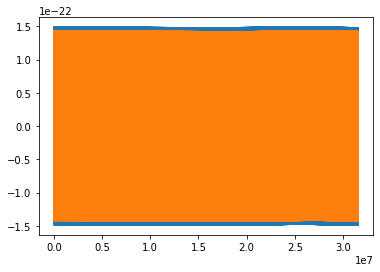

In [ ]:
A = 1e-22 
f = 4e-3
fdot = 1e-16
phi0 = np.pi/3.
inc = np.pi / 4.
psi = 0.2
dt = 10.
T = 1.

%timeit wave1 = gb_wave(A, f, fdot, phi0, inc, psi, T=T, dt=dt, xp=np)
%timeit wave2 = gb_wave(A, f, fdot, phi0, inc, psi, T=T, dt=dt, xp=xp)
%timeit wave3 = gb_wave(A, f, fdot, phi0, inc, psi, T=T, dt=dt, xp=xp, use_numba_cuda=True)

wave1 = gb_wave(A, f, fdot, phi0, inc, psi, T=T, dt=dt, xp=np)
wave2 = gb_wave(A, f, fdot, phi0, inc, psi, T=T, dt=dt, xp=xp)
wave3 = gb_wave(A, f, fdot, phi0, inc, psi, T=T, dt=dt, xp=xp, use_numba_cuda=True)

assert(np.allclose(wave1, wave2.get()))
assert(np.allclose(wave1, wave3.get()))
t = np.arange(len(wave1)) * dt
plt.plot(t, wave1.real)
plt.plot(t, wave1.imag)


### Vectorizing Galctic Binary Waveforms

We will now repeat the exact same exercise, but we will vectorize the process so that we are creating more than one waveform at once. In most gravitational wave applications, it will be advantageous to vectorize over multiple simultaneous computations in order to more fully take advantage of GPU resources. How far you can stretch this concept depends on the problem at hand (compute intensity and memory needs) and the GPU you have access to (memory and compute capacity). 

The functions will be very similar to above with small changes for the dimension over binaries now added. 

Therefore, our kernel function now takes arrays of parameters rather than scalar values. It also takes flattened 2D arrays for `hp` and `hc`, as well as an integer indicator of how many binaries we have.

We will parallelize this so that we still use threads/blocks down the x dimension for calculating each individual waveform, just as before. We will add the y direction for the blocks to indicate which binary we are looking at now. 

In [ ]:
import math

@cuda.jit
def gb_wave_kernel_vectorized(hp, hc, t, A_arr, f_arr, fdot_arr, phi0_arr, inc_arr, psi_arr, n, num_bin):
    """
    Vectorized GB waveforms.
    """

    # get incrementing information down x axis of Grid
    start = cuda.threadIdx.x + cuda.blockIdx.x * cuda.blockDim.x
    increment = cuda.blockDim.x * cuda.gridDim.x

    # "loop" over binaries
    for j in range(cuda.blockIdx.y, num_bin, cuda.gridDim.y):

        # do not have to wory about memory coalescence here as it is only reading one value
        # if we put all the parameters in one array and read them into a shared memory array
        # then, we could use memory coalescence
        A = A_arr[j]
        f = f_arr[j]
        fdot = fdot_arr[j]
        phi0 = phi0_arr[j]
        inc = inc_arr[j]
        psi = psi_arr[j]

        # "loop" over the points in each individual waveform
        for i in range(start, n, increment):
            # make one read to memory for t
            t_here = t[i]
            hpS = -(1 + math.cos(inc) ** 2) * A * math.cos(2 * np.pi * (f * t_here + 1 / 2 * fdot * t_here ** 2) + phi0)
            hcS = -(2 * math.sin(inc)) * A * math.sin(2 * np.pi * (f * t_here + 1 / 2 * fdot * t_here ** 2) + phi0)

            # memory is easily coalesced in this example
            hp[j * n + i] = math.cos(2 * psi) * hpS - math.sin(2 * psi) * hcS
            hc[j * n + i] = math.sin(2 * psi) * hpS + math.cos(2 * psi) * hcS
    

We will once again produce an almost duplicate function to before, just updating everything for the increase in dimensionality. 

In [ ]:
from scipy.constants import Julian_year as YEAR
def gb_wave_vectorized(A_arr, f_arr, fdot_arr, phi0_arr, inc_arr, psi_arr, xp=None, dt=10.0, T=1.0, use_numba_cuda=False):

    # make sure we are using numpy if nothing input
    if xp is None:
      xp = np

    # number of binaries
    num_bin = A_arr.shape[0]

    # integer number of points in the observation time
    N = int(T * YEAR/ dt)

    # generate constantly spaced t vector
    t = xp.arange(N) * dt

    A_arr, f_arr, fdot_arr, phi0_arr, inc_arr, psi_arr = xp.asarray(A_arr), xp.asarray(f_arr), xp.asarray(fdot_arr), xp.asarray(phi0_arr), xp.asarray(inc_arr), xp.asarray(psi_arr)

    # make sure that if use_numba_cuda == True, xp=cupy or else
    # CPU arrays will be put into numba kernels
    if use_numba_cuda and xp != xp:
        raise ValueError("Using numbda cuda requires xp to be cupy.")

    elif use_numba_cuda:

        # allocate buffers for output. 
        # need num_bin * single waveform allocation
        # since x axis has threads, memory coalescence requires innermost axis to be an individual waveform
        # these are declared as flat, but they represent an array of shape (num_bin, len(t))
        hp = xp.zeros(num_bin * len(t))
        hc = xp.zeros(num_bin * len(t))

        # set up and call kernel
        # parallelize along x axis (threads and blocks) and y axis (blocks)
        # x-axis: per waveform
        # y-axis: which waveform
        threadsperblock = 64

        # calculate blocks needed along x
        blockspergrid = (len(t) + (threadsperblock - 1)) // threadsperblock

        # 2D grid (ignoring 1)
        grid = (blockspergrid, num_bin, 1)
        gb_wave_kernel_vectorized[grid, threadsperblock](hp, hc, t, A_arr, f_arr, fdot_arr, phi0_arr, inc_arr, psi_arr, N, num_bin)
        cuda.synchronize()

        # reshape output
        hp = hp.reshape(num_bin, -1)
        hc = hc.reshape(num_bin, -1)

    else:
         # numpy or cupy
        hpS = -(1 + xp.cos(inc_arr[:, None]) ** 2) * A_arr[:, None] * xp.cos(2 * np.pi * (f_arr[:, None] * t[None, :] + 1 / 2 * fdot_arr[:, None] * t[None, :] ** 2) + phi0_arr[:, None])
        hcS = -(2 * xp.sin(inc_arr[:, None])) * A_arr[:, None] * xp.sin(2 * np.pi * (f_arr[:, None] * t[None, :] + 1 / 2 * fdot_arr[:, None] * t[None, :] ** 2) + phi0_arr[:, None])

        hp = xp.cos(2 * psi_arr[:, None]) * hpS - xp.sin(2 * psi_arr[:, None]) * hcS
        hc = xp.sin(2 * psi_arr[:, None]) * hpS + xp.cos(2 * psi_arr[:, None]) * hcS

        
    cuda.synchronize()
    return hp + 1j * hc

1.11 s ± 6.51 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
35.9 ms ± 121 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
28.2 ms ± 1.22 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


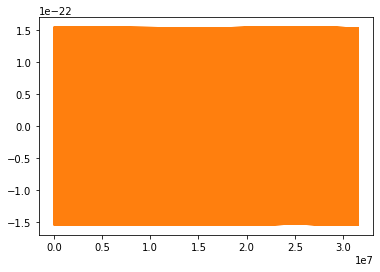

In [ ]:
A_arr = np.array([1e-22, 2e-22, 3e-22, 4e-22, 5e-22])
f_arr = np.array([4e-3, 3e-3, 2e-3, 5e-3, 4e-3])
fdot_arr = np.array([1e-16, 1e-17, 5e-16, 2e-16, 3e-16])
phi0_arr = np.array([np.pi / 3., np.pi / 4., np.pi / 5., np.pi / 2, np.pi / 6])
inc_arr = np.array([np.pi / 5., np.pi / 3., np.pi / 6., np.pi / 8., np.pi / 7])
psi_arr = np.array([np.pi / 3., np.pi / 10., np.pi / 7., np.pi / 4.5, np.pi / 3])

dt = 10.
T = 1.

%timeit wave1 = gb_wave_vectorized(A_arr, f_arr, fdot_arr, phi0_arr, inc_arr, psi_arr, T=T, dt=dt, xp=np)
%timeit wave2 = gb_wave_vectorized(A_arr, f_arr, fdot_arr, phi0_arr, inc_arr, psi_arr, T=T, dt=dt, xp=xp)
%timeit wave3 = gb_wave_vectorized(A_arr, f_arr, fdot_arr, phi0_arr, inc_arr, psi_arr, T=T, dt=dt, xp=xp, use_numba_cuda=True)

wave1 = gb_wave_vectorized(A_arr, f_arr, fdot_arr, phi0_arr, inc_arr, psi_arr, T=T, dt=dt, xp=np)
wave2 = gb_wave_vectorized(A_arr, f_arr, fdot_arr, phi0_arr, inc_arr, psi_arr, T=T, dt=dt, xp=xp)
wave3 = gb_wave_vectorized(A_arr, f_arr, fdot_arr, phi0_arr, inc_arr, psi_arr, T=T, dt=dt, xp=xp, use_numba_cuda=True)

assert(np.allclose(wave1, wave2.get()))
assert(np.allclose(wave1, wave3.get()))
t = np.arange(len(wave1[0])) * dt
plt.plot(t, wave1[0].real)
plt.plot(t, wave1[0].imag)


With these waveforms stored in GPU global memory, we will not compute an inner product on the GPU. For this we will use `CuPy`. We could also code this up with `numba.cuda` Atomic operations. `CuPy` will be faster than the Atomic operation-based kernel because `CuPy` will automatically perform a Reduction Operation. These were briefly mentioned above. Reduction methods would be the most efficient method to calculate Likelihoods for most sources.

For this we are going to need a LISA sensitivity curve. The formula for the inner product we will use is

$$\langle a | b \rangle = 4\Re\int_0^\infty \frac{\tilde{a}(f)^*\tilde{b}(f)}{S_n(f)}df.$$

In [ ]:
# prepare LISA sensitivity


# likelihood for the 5

# get the FFT
%timeit hf_p = xp.fft.rfft(wave2.real, axis=-1)
%timeit hf_p_cpu = np.fft.rfft(wave1.real, axis=-1)

# multiply by dt for proper dimensions
hf_p = xp.fft.rfft(wave2.real, axis=-1) * dt
hf_c = xp.fft.rfft(wave2.imag, axis=-1) * dt

hf_p_cpu = np.fft.rfft(wave1.real, axis=-1) * dt
hf_c_cpu = np.fft.rfft(wave1.imag, axis=-1) * dt

#
N = hf_p.shape[1]
df = 1 / (dt * N)
Sn_cpu = np.ones(N) * 1e-40
Sn = xp.ones(N) * 1e-40

%timeit inner_product = 4 * df * xp.sum((hf_p.conj() * hf_p)/Sn, axis=-1).real
%timeit inner_product = 4 * df * np.sum((hf_p_cpu.conj() * hf_p_cpu)/Sn_cpu, axis=-1).real

inner_product = 4 * df * xp.sum((hf_p.conj() * hf_p)/Sn, axis=-1).real
inner_product_cpu = 4 * df * np.sum((hf_p_cpu.conj() * hf_p_cpu)/Sn_cpu, axis=-1).real

assert np.allclose(inner_product_cpu, inner_product.get())

51.6 ms ± 326 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
1.99 s ± 416 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
137 µs ± 70.3 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
100 ms ± 936 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
